## Analysis of Buck Converter Data

The simulation data was saved as a hdf5 database in the folder: C:\Users\JC28LS\OneDrive - Aalborg Universitet\Desktop\Work\Databases. 

In [2]:
from pathlib import Path
import h5py

from h5_auxiliaries.read_h5 import explore_h5

directory = Path(r"C:\Users\JC28LS\OneDrive - Aalborg Universitet\Desktop\Work\Databases")
db_name = "buck_converter_Shuai"
explore_h5(directory / f"{db_name}")

[1] Group   original_format
	[2] Group   original_format/0
		[3] Dataset original_format/0/Current - shape: (1440, 1), dtype: float64
		[3] Dataset original_format/0/CurrentInput - shape: (1440, 1), dtype: float64
		[3] Dataset original_format/0/CurrentInputLower - shape: (1440, 1), dtype: float64
		[3] Dataset original_format/0/Dswitch - shape: (1440, 1), dtype: uint8
		[3] Dataset original_format/0/DswitchLower - shape: (1440, 1), dtype: float64
		[3] Dataset original_format/0/DswitchTransform - shape: (1440, 1), dtype: uint16
		[3] Dataset original_format/0/Rload - shape: (1440, 1), dtype: float64
		[3] Dataset original_format/0/RloadLower - shape: (722, 1), dtype: float64
		[3] Dataset original_format/0/Voltage - shape: (1440, 1), dtype: float64
		[3] Dataset original_format/0/VoltageInput - shape: (1440, 1), dtype: float64
		[3] Dataset original_format/0/VoltageInputLower - shape: (1440, 1), dtype: float64
		[3] Dataset original_format/0/dt - shape: (1440, 1), dtype: float64
		[3]

In [3]:
# check the attributes of the first group
macrogroup_name = "original_format"
with h5py.File(directory / f"{db_name}.h5", "r") as f:
    print(f"Attributes of the first group '{macrogroup_name}':")
    for attr in f[macrogroup_name].attrs:
        print(f"{attr}: {f[macrogroup_name].attrs[attr]}")

Attributes of the first group 'original_format':
created_by: load_simul_data.py script
created_on: 2025-05-27T13:22:59.658407
description: 
            
            Original simulation data loaded from MATLAB .mat files. 
            Each subgroup corresponds to a different transient. Each subgroup corresponding to a transient 
            contains the data signals from the simulation: 
            +	"Current", Shape: (1440, 1), Dtype: float64
            +    "CurrentInput", Shape: (1440, 1), Dtype: float64
            +    "CurrentInputLower", Shape: (1440, 1), Dtype: float64
            +    "Dswitch", Shape: (1440, 1), Dtype: uint8
            +    "DswitchLower", Shape: (1440, 1), Dtype: float64
            +    "DswitchTransform", Shape: (1440, 1), Dtype: uint16
            +    "Rload", Shape: (1440, 1), Dtype: float64
            +    "RloadLower", Shape: (722, 1), Dtype: float64
            +    "Voltage", Shape: (1440, 1), Dtype: float64
            +    "VoltageInput", Shape

Different groups of measurements are saved in the h5 database. These probably correspond to different transient mentioned in the paper.

Let's focus on one of these and look at the quantities. 

In [4]:
import h5py

# Open the HDF5 file and load the first group
with h5py.File(directory / f"{db_name}.h5", "r") as f:
        # Access the first group
        group = f[f"{macrogroup_name}/0"]
        print("\nAttributes of the group:")
        for attr_name, attr_value in group.attrs.items():
            print(f"{attr_name}: {attr_value}")
        # Access the first dataset in the group
        print("\nDatasets in the group:\n")
        for dataset_name in group:
            dataset = group[dataset_name]
            print(f"\t\"{dataset_name}\", Shape: {dataset.shape}, Dtype: {dataset.dtype}")
           


Attributes of the group:
__globals__: []
__header__: MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Sep  2 14:37:20 2021
__version__: 1.0
mat_file: 0
source: C:\Users\JC28LS\OneDrive - Aalborg Universitet\Desktop\Work\PIML_Converter\Simulation_data\0.mat

Datasets in the group:

	"Current", Shape: (1440, 1), Dtype: float64
	"CurrentInput", Shape: (1440, 1), Dtype: float64
	"CurrentInputLower", Shape: (1440, 1), Dtype: float64
	"Dswitch", Shape: (1440, 1), Dtype: uint8
	"DswitchLower", Shape: (1440, 1), Dtype: float64
	"DswitchTransform", Shape: (1440, 1), Dtype: uint16
	"Rload", Shape: (1440, 1), Dtype: float64
	"RloadLower", Shape: (722, 1), Dtype: float64
	"Voltage", Shape: (1440, 1), Dtype: float64
	"VoltageInput", Shape: (1440, 1), Dtype: float64
	"VoltageInputLower", Shape: (1440, 1), Dtype: float64
	"dt", Shape: (1440, 1), Dtype: float64
	"forwaredBackwaredIndicator", Shape: (1440, 2), Dtype: int16
	"res", Shape: (1, 1), Dtype: uint8
	"t", Shape: (1440, 1), Dtype: float

In the paper the following dynamic systems are established for the buck converter: 

\begin{align*} 
&\frac{di_{L}}{dt} + \frac{\left[\begin{array}{c}(S\cdot R_{dson}+R_{L})i_{L}+v_{o}\\ -S\cdot V_{\text{in}}+(1-S)\cdot V_{F} \end{array}\right]}{L} =0  
\\
&\frac{dv_{o}}{dt}+\frac{v_{o}+C\cdot R_{C}\cdot R\cdot \mathcal {N}[i_{L};\boldsymbol{\theta }]-R\cdot i_{L}}{C\cdot (R_{c}+R)}=0 \end{align*}

Let's try focusing on the first of these equations: 

\begin{equation*}
\frac{di_{L}}{dt} + \frac{\left[\begin{array}{c}(S\cdot R_{dson}+R_{L})i_{L}+v_{o}\\ -S\cdot V_{\text{in}}+(1-S)\cdot V_{F} \end{array}\right]}{L} =0  
\end{equation*}

We need the quatities:

* $\frac{di_{L}}{dt}$
* $i_{L}$
* $S$
* $R_{dson}$
* $R_{L}$
* $v_o$
* $V_{\text{in}}$
* $V_{F}$
* $L$

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Extract some datasets
with h5py.File(directory / f"{db_name}.h5", "r") as f:
    group = f[f"{macrogroup_name}/0"]
    
    # i_L datasets
    i_: np.ndarray = group["Current"][:].squeeze()
    i_in: np.ndarray = group["CurrentInput"][:].squeeze()
    i_in_lower: np.ndarray = group["CurrentInputLower"][:].squeeze()
    
    # v datasets
    v_: np.ndarray = group["Voltage"][:].squeeze()
    v_in: np.ndarray = group["VoltageInput"][:].squeeze()
    v_in_lower: np.ndarray = group["VoltageInputLower"][:].squeeze()
    
    
    # t datasets
    t: np.ndarray = group["t"][:].squeeze()
    dt: np.ndarray = group["dt"][:].squeeze()
    t_lower: np.ndarray = group["tLower"][:].squeeze()
    
    # d switch datasets
    d_switch: np.ndarray = group["Dswitch"][:].squeeze()
    d_switch_lower: np.ndarray = group["DswitchLower"][:].squeeze()
    d_switch_transform: np.ndarray = group["DswitchTransform"][:].squeeze()

# Print the shapes of the extracted dataset

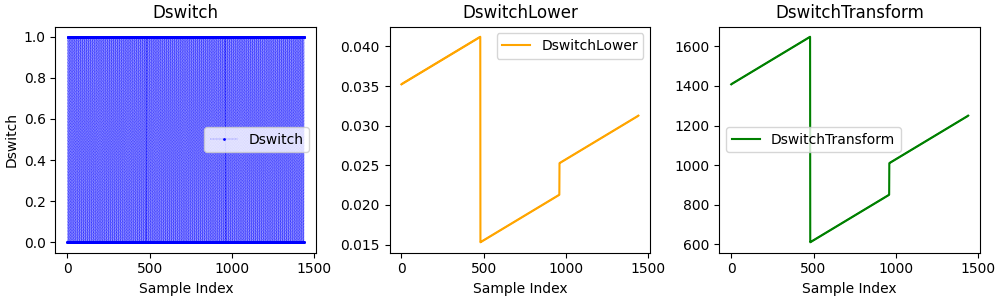

In [6]:
%matplotlib widget

# The logical signal S?

fig, ax = plt.subplots(1, 3, figsize=(10, 3), constrained_layout=True)
ax[0].plot(d_switch, linestyle="--", linewidth=0.2, marker='o', markersize=1, label="Dswitch", color="blue")
ax[0].set_ylabel("Dswitch")
ax[0].set_xlabel("Sample Index")
ax[0].set_title("Dswitch")
ax[0].legend()

ax[1].plot(d_switch_lower, label="DswitchLower", color="orange")
ax[1].set_xlabel("Sample Index")
ax[1].set_title("DswitchLower")
ax[1].legend()

ax[2].plot(d_switch_transform, label="DswitchTransform", color="green")
ax[2].set_title("DswitchTransform")
ax[2].set_xlabel("Sample Index")
ax[2].legend()

# what are these datasets?

Many values are zero! also we see a **similar profile in the charging and discharging phases...**

# Sanity Check 
In the following section we check that indeed the measured values are reported in **identical pairs!**. 


In [7]:
import pandas as pd

class SanityCheckFuncs:
    @staticmethod
    def print_diff_pairs(arr, name="array", start=0, num_pairs=3):
        """
        Print non-overlapping pairs starting from index `start`,
        along with their absolute difference.
        """
        total_rows = arr.shape[0]
        max_pairs = (total_rows - start) // 2
        num_pairs = min(num_pairs, max_pairs)

        print(f"\n{name} – printing {num_pairs} pairs starting from index {start}:")
        for i in range(num_pairs):
            idx_a = start + 2 * i
            idx_b = start + 2 * i + 1
            a = arr[idx_a]
            b = arr[idx_b]
            print(f"  [{idx_a}] {a}")
            print(f"  [{idx_b}] {b}")
            print(f"   ↪ Δ = {np.abs(b - a)}\n")

        if num_pairs == 0:
            print("  ⚠️ Not enough rows to form a pair from the given start index.")

    @staticmethod
    def pairwise_diff_df(arr: np.ndarray, name="array"):
      """
      Builds a pandas DataFrame comparing all non-overlapping pairs of rows:
      (0,1), (2,3), (4,5), ...
      
      Shows original values and absolute differences.
      """
      assert arr.shape[0] % 2 == 0, "Array must have even number of rows for pairwise comparison."
      if np.ndim(arr) == 1: 
        arr = arr[:, np.newaxis]

      num_pairs = arr.shape[0] // 2
      col_names = [f"{name}_{i}" for i in range(arr.shape[1])]
      data = []

      for i in range(num_pairs):
          idx_a = 2 * i
          idx_b = 2 * i + 1
          row_a = arr[idx_a]
          row_b = arr[idx_b]
          delta = np.abs(row_b - row_a)
          row_dict = {
              "index_a": idx_a,
              "index_b": idx_b,
              **{f"a_{c}": v for c, v in zip(col_names, row_a)},
              **{f"b_{c}": v for c, v in zip(col_names, row_b)},
              **{f"Δ_{c}": d for c, d in zip(col_names, delta)},
          }
          data.append(row_dict)

      df = pd.DataFrame(data)
      return df

    @staticmethod 
    def scatter_plot_differences(arr: np.ndarray, name="array", ax = None, figsize=(10, 5)):
        """
        Scatter plot of absolute differences between pairs of rows.
        """
        assert arr.shape[0] % 2 == 0, "Array must have even number of rows for pairwise comparison."
        if np.ndim(arr) == 1: 
            arr = arr[:, np.newaxis]

        num_pairs = arr.shape[0] // 2
        diffs = np.abs(arr[1::2] - arr[0::2])
        
        if ax is None:
            fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)

        for i in range(diffs.shape[1]):
            ax.bar(range(num_pairs), diffs[:, i], label=f"Δ_{name}_{i}", width=10, align='center')
        
        ax.set_xlabel("Pair Index")
        ax.set_ylabel("Absolute Difference")
        ax.set_title(f"Scatter Plot of Absolute Differences in {name}")
        ax.legend()
        ax.grid()
        return ax
    
    @staticmethod
    def scatter_plot_pairs(arr: np.ndarray, name="array", ax=None, figsize=(10, 5)):
        """
        Scatter plot of pairs of rows.
        """
        if np.ndim(arr) == 1: 
            arr = arr[:, np.newaxis]
        if ax is None:
            fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)

        for i in range(arr.shape[1]):
            ax.scatter(arr[0::2, i], arr[1::2, i], label=f"{name}_{i}", alpha=0.5)
        ax.set_xlabel("Value A")
        ax.set_ylabel("Value B")
        ax.set_title(f"Scatter Plot of Pairs in {name}")
        ax.legend()
        ax.grid()
        return ax
    

### Voltage Sanity Check

In [13]:
v_in[-4:]

array([24.07273172, 24.07273172, 23.89827727, 20.33091827])

Text(0.5, 0.98, 'Voltage: Differences and Pairs')

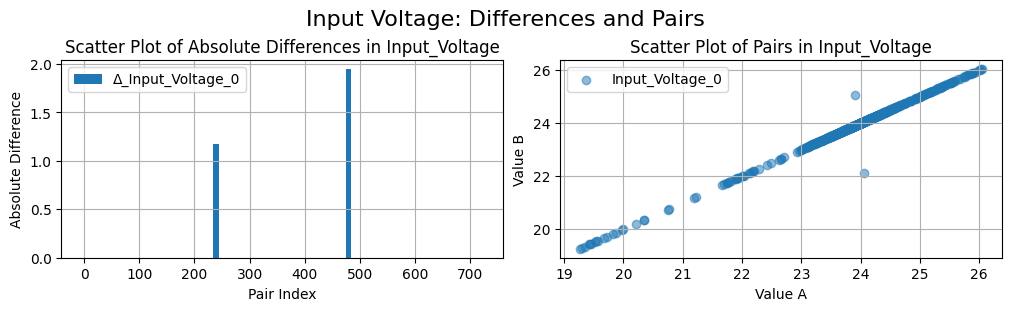

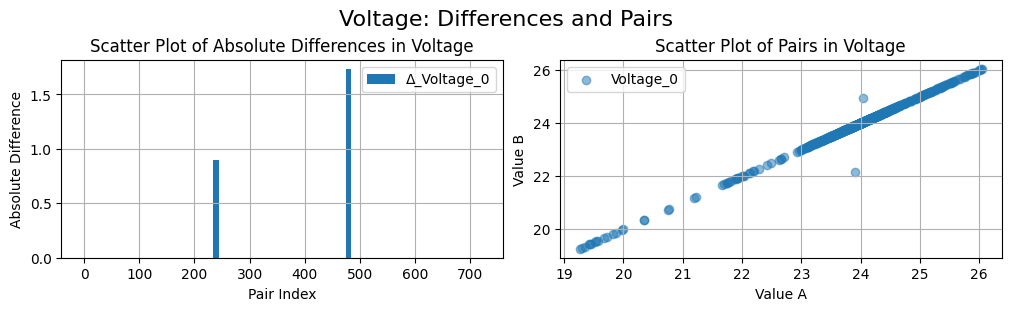

In [134]:
%matplotlib inline

plt.close("all")

fig, ax = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)
SanityCheckFuncs.scatter_plot_differences(v_in[:-2], name="Input_Voltage", ax=ax[0])
SanityCheckFuncs.scatter_plot_pairs(v_in[:-2], name="Input_Voltage", ax=ax[1])
fig.suptitle("Input Voltage: Differences and Pairs", fontsize=16)

fig, ax = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)
SanityCheckFuncs.scatter_plot_differences(v_[1:-1], name="Voltage", ax=ax[0])
SanityCheckFuncs.scatter_plot_pairs(v_[1:-1], name="Voltage", ax=ax[1])
fig.suptitle("Voltage: Differences and Pairs", fontsize=16)

In [135]:
V_diff_df = SanityCheckFuncs.pairwise_diff_df(v_in[:-2], name="Input_Voltage")
# get the column that holds the differences
delta_cols = [col for col in V_diff_df.columns if col.startswith("Δ_")]

# count the number of rows where delta_cols is not zero
nonzero_mask = (V_diff_df[delta_cols] != 0).any(axis=1)
number_of_nonzero_differences = nonzero_mask.sum()

print(f"There are {number_of_nonzero_differences} non-zero Δ between following steps")

# order the table to show the elements with largest difference first
V_diff_df.sort_values(by=delta_cols[0], ascending=False).head(3)

There are 2 non-zero Δ between following steps


,index_a,index_b,a_Input_Voltage_0,b_Input_Voltage_0,Δ_Input_Voltage_0
479,958,959,24.057189,22.113152,1.944037
239,478,479,23.899845,25.073282,1.173437
4,8,9,19.565001,19.565001,0.000000


In [136]:
SanityCheckFuncs.print_diff_pairs(v_in, name="Voltage", start=476)
SanityCheckFuncs.print_diff_pairs(v_in, name="Voltage", start=956)

# last value ...
# SanityCheckFuncs.print_diff_pairs(xVoltage, name="Voltage", start=1436)


Voltage – printing 3 pairs starting from index 476:
  [476] 24.05653036375099
  [477] 24.05653036375099
   ↪ Δ = 0.0

  [478] 23.89984512299903
  [479] 25.073281906677952
   ↪ Δ = 1.1734367836789232

  [480] 24.94337770173769
  [481] 24.94337770173769
   ↪ Δ = 0.0


Voltage – printing 3 pairs starting from index 956:
  [956] 23.884537679676388
  [957] 23.884537679676388
   ↪ Δ = 0.0

  [958] 24.05718870120063
  [959] 22.113151966402754
   ↪ Δ = 1.9440367347978764

  [960] 22.17040842395416
  [961] 22.17040842395416
   ↪ Δ = 0.0



### Current Sanity Check

Text(0.5, 0.98, 'Current: Differences and Pairs')

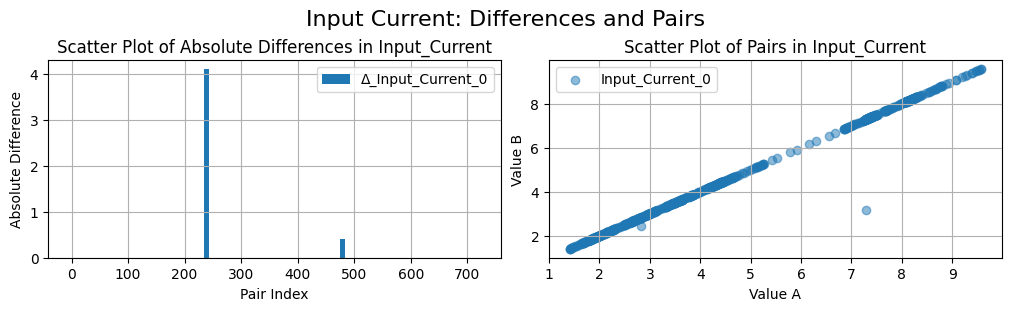

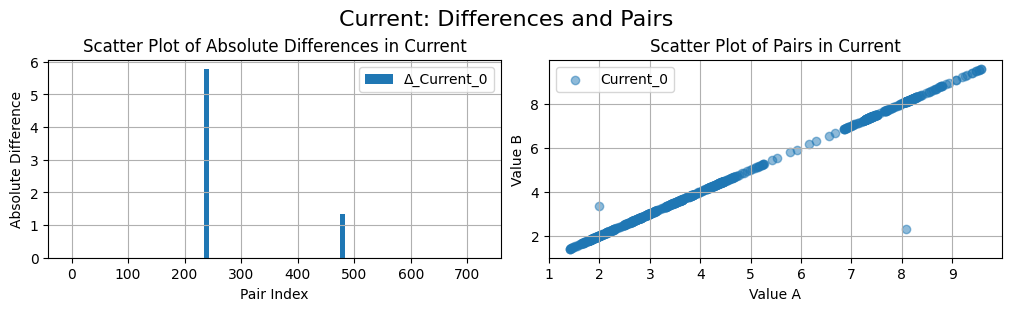

In [137]:
%matplotlib inline

plt.close("all")

fig, ax = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)
SanityCheckFuncs.scatter_plot_differences(i_in[:-2], name="Input_Current", ax=ax[0])
SanityCheckFuncs.scatter_plot_pairs(i_in[:-2], name="Input_Current", ax=ax[1])
fig.suptitle("Input Current: Differences and Pairs", fontsize=16)

fig, ax = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)
SanityCheckFuncs.scatter_plot_differences(i_[1:-1], name="Current", ax=ax[0])
SanityCheckFuncs.scatter_plot_pairs(i_[1:-1], name="Current", ax=ax[1])
fig.suptitle("Current: Differences and Pairs", fontsize=16)

In [138]:
# intput current differences
print("Input Current Pair Differences: ")
df_in = SanityCheckFuncs.pairwise_diff_df(i_in[:-2], name="Input_Current")
# get the column that holds the differences
delta_cols = [col for col in df_in.columns if col.startswith("Δ_")]

# count the number of rows where delta_cols is not zero
nonzero_mask = (df_in[delta_cols] != 0).any(axis=1)
number_of_nonzero_differences = nonzero_mask.sum()

print(f"There are {number_of_nonzero_differences} non-zero Δ between following steps")

# order the table to show the elements with largest difference first
print(df_in.sort_values(by=delta_cols[0], ascending=False).head(3))


# current differences
df_in = SanityCheckFuncs.pairwise_diff_df(i_[1:-1], name="Current")
# get the column that holds the differences
delta_cols = [col for col in df_in.columns if col.startswith("Δ_")]

# count the number of rows where delta_cols is not zero
nonzero_mask = (df_in[delta_cols] != 0).any(axis=1)
number_of_nonzero_differences = nonzero_mask.sum()

print(f"There are {number_of_nonzero_differences} non-zero Δ between following steps")

# order the table to show the elements with largest difference first
print(df_in.sort_values(by=delta_cols[0], ascending=False).head(3))

Input Current Pair Differences: 
There are 2 non-zero Δ between following steps
     index_a  index_b  a_Input_Current_0  b_Input_Current_0  Δ_Input_Current_0
239      478      479           7.288057           3.187966           4.100092
479      958      959           2.818448           2.421128           0.397320
4          8        9           5.784107           5.784107           0.000000
There are 2 non-zero Δ between following steps
     index_a  index_b  a_Current_0  b_Current_0  Δ_Current_0
239      478      479     8.082357     2.316613     5.765744
479      958      959     1.984069     3.330586     1.346518
4          8        9     5.135704     5.135704     0.000000


### Switching Sanity Check

In [14]:
d_switch[:10]

array([0, 0, 1, 1, 0, 0, 1, 1, 0, 0], dtype=uint8)

<Axes: title={'center': 'Scatter Plot of Absolute Differences in Switching Difference'}, xlabel='Pair Index', ylabel='Absolute Difference'>

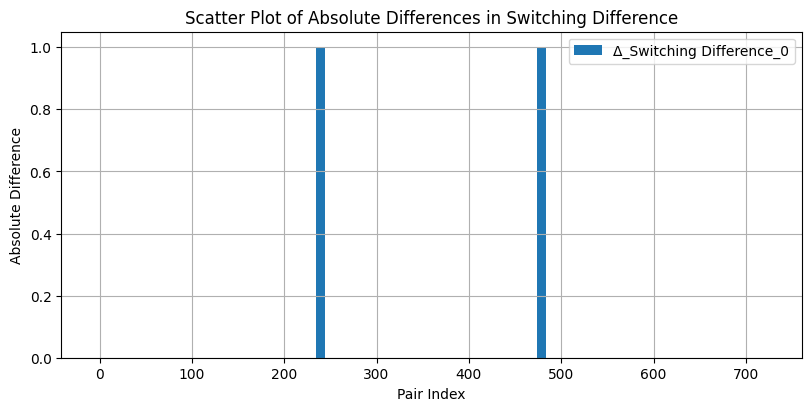

In [139]:
%matplotlib inline

plt.close("all")

fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)
SanityCheckFuncs.scatter_plot_differences(d_switch.astype(np.int32), name="Switching Difference", ax=ax)

In [140]:
print("Switching Signal Pair Differences: ")
df_in = SanityCheckFuncs.pairwise_diff_df(d_switch.astype(np.int32), name="S")
# get the column that holds the differences
delta_cols = [col for col in df_in.columns if col.startswith("Δ_")]

# count the number of rows where delta_cols is not zero
nonzero_mask = (df_in[delta_cols] != 0).any(axis=1)
number_of_nonzero_differences = nonzero_mask.sum()

print(f"There are {number_of_nonzero_differences} non-zero Δ between following steps")

# order the table to show the elements with largest difference first
print(df_in.sort_values(by=delta_cols[0], ascending=False).head(3))

Switching Signal Pair Differences: 
There are 2 non-zero Δ between following steps
     index_a  index_b  a_S_0  b_S_0  Δ_S_0
239      478      479      1      0      1
479      958      959      0      1      1
1          2        3      1      1      0


### Switching Time Sanity Check

Text(0.5, 0.98, 'Switching Time: Differences and Pairs')

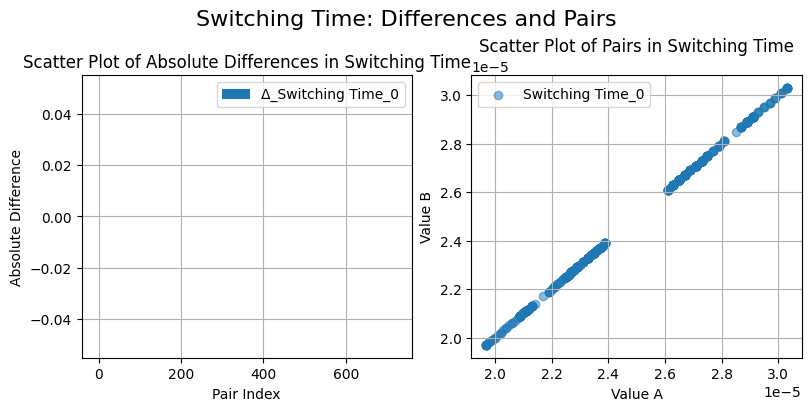

In [141]:
%matplotlib inline

plt.close("all")

fig, ax = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)
SanityCheckFuncs.scatter_plot_differences(dt, name="Switching Time", ax=ax[0])
SanityCheckFuncs.scatter_plot_pairs(dt, name="Switching Time", ax=ax[1])
fig.suptitle("Switching Time: Differences and Pairs", fontsize=16)

In [142]:
# switching time differences
print("Switching Time Pair Differences: ")
df_in = SanityCheckFuncs.pairwise_diff_df(dt, name="dt")
# get the column that holds the differences
delta_cols = [col for col in df_in.columns if col.startswith("Δ_")]

# count the number of rows where delta_cols is not zero
nonzero_mask = (df_in[delta_cols] != 0).any(axis=1)
number_of_nonzero_differences = nonzero_mask.sum()

print(f"There are {number_of_nonzero_differences} non-zero Δ between following steps")

Switching Time Pair Differences: 
There are 0 non-zero Δ between following steps


# Initial vs End Conditions of Switching Transients

In [143]:
import pandas as pd
import seaborn as sns

X = np.stack([v_in, v_], axis=1)

df = pd.DataFrame(X, columns=["v_in", "v"])
print(df.head(10))

        v_in          v
0  20.207044  20.207044
1  20.207044  19.868352
2  19.868352  19.868352
3  19.868352  19.818609
4  19.818609  19.818609
5  19.818609  19.541361
6  19.541361  19.541361
7  19.541361  19.565001
8  19.565001  19.565001
9  19.565001  19.343571


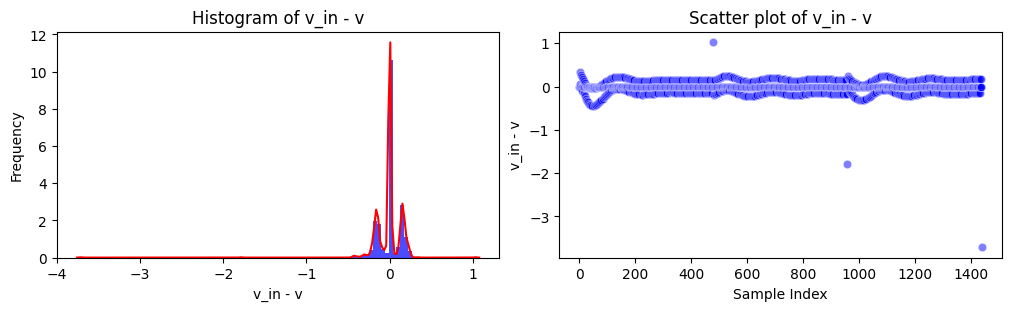

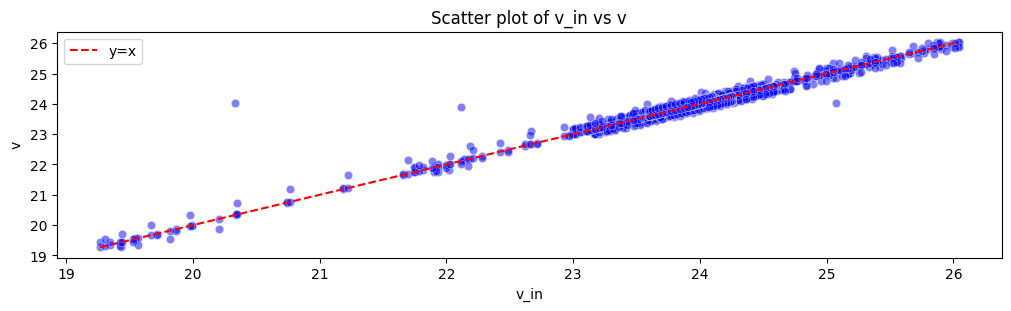

In [144]:
# plot histogram of v_in and v with kde estimate
fig, ax = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)
ax[0].hist(df["v_in"] - df["v"], bins=100, color="blue", alpha=0.7, label="v_in - v", density=True)
ax[0].set_title("Histogram of v_in - v")
# kde estimate
sns.kdeplot(df["v_in"] - df["v"], ax=ax[0], color="red", label="KDE", bw_adjust=0.4)
ax[0].set_xlabel("v_in - v")
ax[0].set_ylabel("Frequency")

# Scatter plot of v_in - v
data = df["v_in"] - df["v"]
sns.scatterplot(x=df.index, y=data, ax=ax[1], color="blue", alpha=0.5)
ax[1].set_title("Scatter plot of v_in - v")
ax[1].set_xlabel("Sample Index")
ax[1].set_ylabel("v_in - v")

fig, ax = plt.subplots(1, figsize=(10, 3), constrained_layout=True)

# scatter plot of v_in vs v
sns.scatterplot(x=df["v_in"], y=df["v"], ax=ax, color="blue", alpha=0.5)
ax.set_title("Scatter plot of v_in vs v")
ax.set_xlabel("v_in")
ax.set_ylabel("v")
# plot the line y=x
ax.plot(
    [df["v_in"].min(), df["v_in"].max()],
    [df["v_in"].min(), df["v_in"].max()],
    color="red",
    linestyle="--",
    label="y=x",
)
ax.legend()

In [148]:
# Remove doubled values

X_hat = X[1::2]

df_hat = pd.DataFrame(X_hat, columns=["v_in", "v"])
print(df_hat.head(5))

        v_in          v
0  20.207044  19.868352
1  19.868352  19.818609
2  19.818609  19.541361
3  19.541361  19.565001
4  19.565001  19.343571


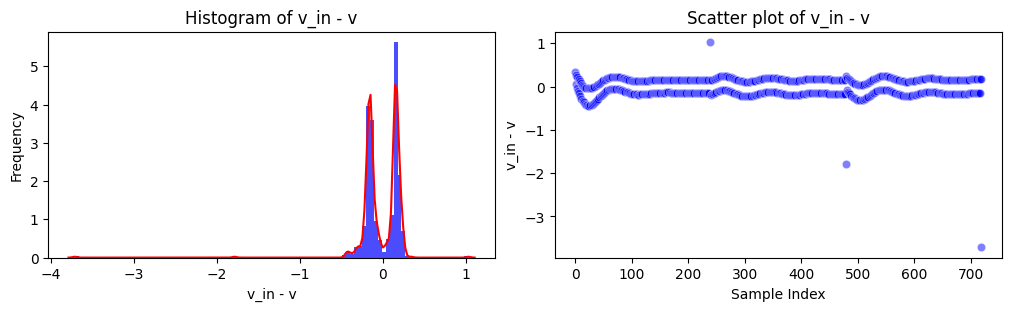

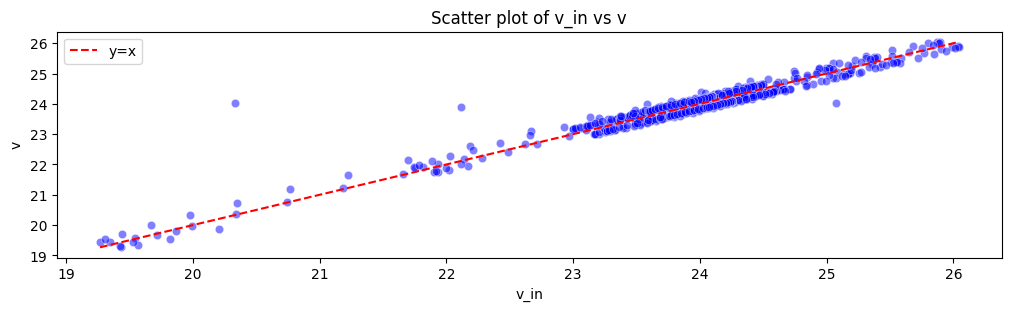

In [149]:
# plot histogram of v_in and v with kde estimate
fig, ax = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)
ax[0].hist(df_hat["v_in"] - df_hat["v"], bins=100, color="blue", alpha=0.7, label="v_in - v", density=True)
ax[0].set_title("Histogram of v_in - v")
# kde estimate
sns.kdeplot(df_hat["v_in"] - df_hat["v"], ax=ax[0], color="red", label="KDE", bw_adjust=0.4)
ax[0].set_xlabel("v_in - v")
ax[0].set_ylabel("Frequency")

# Scatter plot of v_in - v
data = df_hat["v_in"] - df_hat["v"]
sns.scatterplot(x=df_hat.index, y=data, ax=ax[1], color="blue", alpha=0.5)
ax[1].set_title("Scatter plot of v_in - v")
ax[1].set_xlabel("Sample Index")
ax[1].set_ylabel("v_in - v")

fig, ax = plt.subplots(1, figsize=(10, 3), constrained_layout=True)

# scatter plot of v_in vs v
sns.scatterplot(x=df_hat["v_in"], y=df_hat["v"], ax=ax, color="blue", alpha=0.5)
ax.set_title("Scatter plot of v_in vs v")
ax.set_xlabel("v_in")
ax.set_ylabel("v")
# plot the line y=x
ax.plot(
    [df_hat["v_in"].min(), df_hat["v_in"].max()],
    [df_hat["v_in"].min(), df_hat["v_in"].max()],
    color="red",
    linestyle="--",
    label="y=x",
)
ax.legend()

## Plot Original Quantities

<>:30: SyntaxWarning: invalid escape sequence '\D'
<>:30: SyntaxWarning: invalid escape sequence '\D'
C:\Users\JC28LS\AppData\Local\Temp\ipykernel_7580\1504781101.py:30: SyntaxWarning: invalid escape sequence '\D'
  ax[2].plot(t_trans, label="$\Delta t$", color="blue")


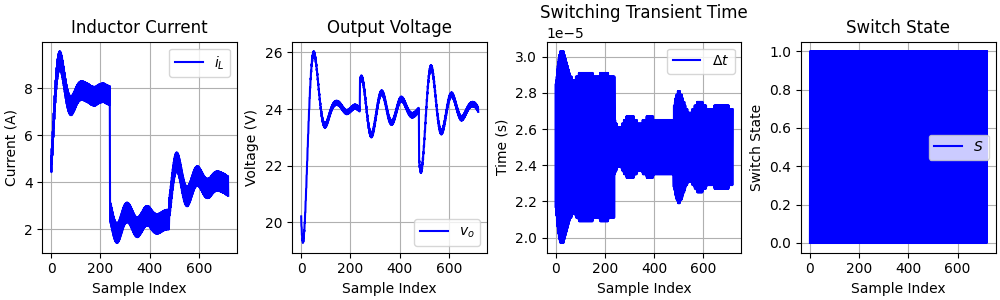

In [17]:
%matplotlib widget

i = np.append(i_in[1:-1:2], i_[-2])
v = np.append(v_in[1:-1:2], v_[-2])
s = np.append(d_switch[1:-1:2], d_switch[-2])
t_trans = np.append(dt[1:-1:2], dt[-2])
# the step values are given by the t_trans dataset

t = np.zeros_like(t_trans)
for ii in range(1, len(t_trans)):
    t[ii] = t[ii - 1] + t_trans[ii]


fig, ax = plt.subplots(1, 4, figsize=(10, 3), constrained_layout=True)

ax[0].plot(i, label="$i_L$", color="blue")
ax[0].set_ylabel("Current (A)")
ax[0].set_xlabel("Sample Index")
ax[0].set_title("Inductor Current")
ax[0].legend()
ax[0].grid()

ax[1].plot(v, label="$v_o$", color="blue")
ax[1].set_ylabel("Voltage (V)")
ax[1].set_xlabel("Sample Index")
ax[1].set_title("Output Voltage")
ax[1].legend()
ax[1].grid()

ax[2].plot(t_trans, label="$\Delta t$", color="blue")
ax[2].set_ylabel("Time (s)")
ax[2].set_xlabel("Sample Index")
ax[2].set_title("Switching Transient Time")
ax[2].legend()
ax[2].grid()

ax[3].plot(s, label="$S$", color="blue")
ax[3].set_ylabel("Switch State")
ax[3].set_xlabel("Sample Index")
ax[3].set_title("Switch State")
ax[3].legend()
ax[3].grid()


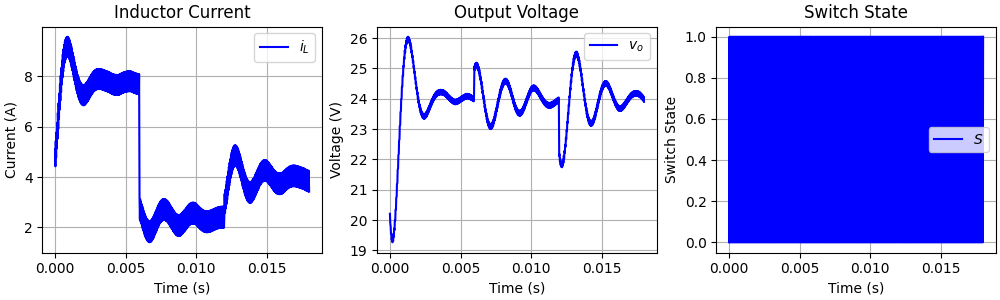

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3), constrained_layout=True)

ax[0].plot(t, i, label="$i_L$", color="blue")
ax[0].set_ylabel("Current (A)")
ax[0].set_xlabel("Time (s)")
ax[0].set_title("Inductor Current")
ax[0].legend()
ax[0].grid()

ax[1].plot(t, v, label="$v_o$", color="blue")
ax[1].set_ylabel("Voltage (V)")
ax[1].set_xlabel("Time (s)")
ax[1].set_title("Output Voltage")
ax[1].legend()
ax[1].grid()

ax[2].plot(t, s, label="$S$", color="blue")
ax[2].set_ylabel("Switch State")
ax[2].set_xlabel("Time (s)")
ax[2].set_title("Switch State")
ax[2].legend()
ax[2].grid()

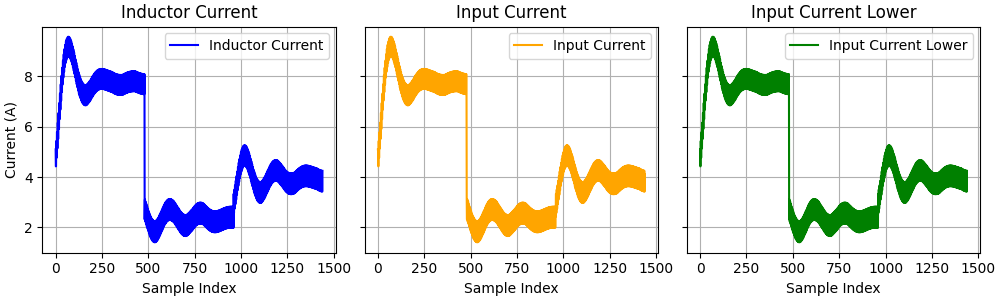

In [7]:
%matplotlib widget

# What are the different current datasets?

fig, ax = plt.subplots(1, 3, figsize=(10, 3), sharey=True, constrained_layout=True)

ax[0].plot(i_, label="Inductor Current", color="blue")
ax[0].set_ylabel("Current (A)")
ax[0].set_xlabel("Sample Index")
ax[0].set_title("Inductor Current")
ax[0].legend()
ax[0].grid()


ax[1].plot(i_in, label="Input Current", color="orange")
ax[1].set_xlabel("Sample Index")
ax[1].set_title("Input Current")
ax[1].legend()
ax[1].grid()

ax[2].plot(i_in_lower, label="Input Current Lower", color="green")
ax[2].set_title("Input Current Lower")
ax[2].set_xlabel("Sample Index")
ax[2].legend()
ax[2].grid()

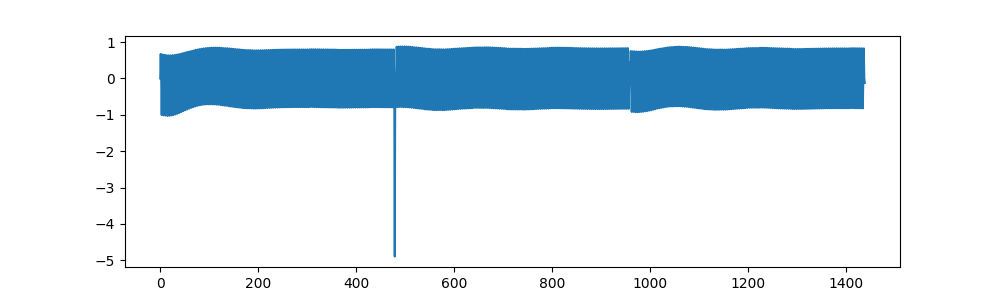

In [19]:
plt.figure(figsize=(10, 3)) 

plt.plot(i_in-i_in_lower)

Text(0.5, 1.0, 'Dataset: "tLower"')

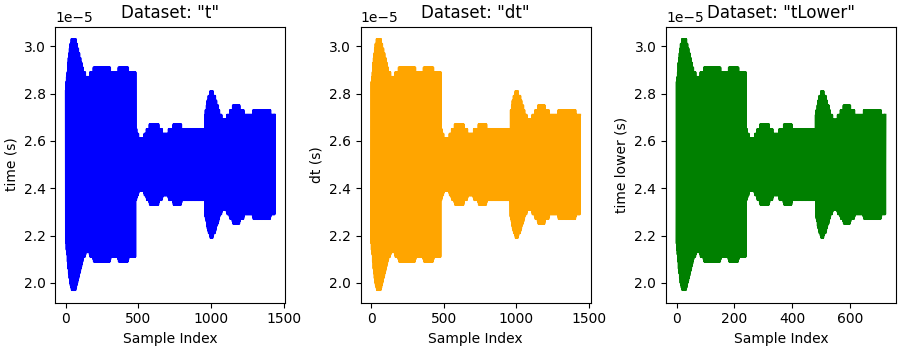

In [11]:
# What are t and dt?

fig, ax = plt.subplots(1, 3, figsize=(9, 3.5), constrained_layout=True)
ax[0].plot(t, color="blue")
ax[0].set_ylabel("time (s)")
ax[0].set_xlabel("Sample Index")
ax[0].set_title("Dataset: \"t\"")

ax[1].plot(dt, color="orange")
ax[1].set_ylabel("dt (s)")
ax[1].set_xlabel("Sample Index")
ax[1].set_title('Dataset: "dt"')

ax[2].plot(t_lower, color="green")
ax[2].set_ylabel("time lower (s)")
ax[2].set_xlabel("Sample Index")
ax[2].set_title('Dataset: "tLower"')


In [15]:
dt[0], dt[1], dt[2], dt[3], dt[4], dt[5], dt[6], dt[7], dt[8], dt[9]

(np.float64(2.1700000000006436e-05),
 np.float64(2.1700000000006436e-05),
 np.float64(2.8499999999993808e-05),
 np.float64(2.8499999999993808e-05),
 np.float64(2.140000000000475e-05),
 np.float64(2.140000000000475e-05),
 np.float64(2.869999999999956e-05),
 np.float64(2.869999999999956e-05),
 np.float64(2.1199999999998997e-05),
 np.float64(2.1199999999998997e-05))

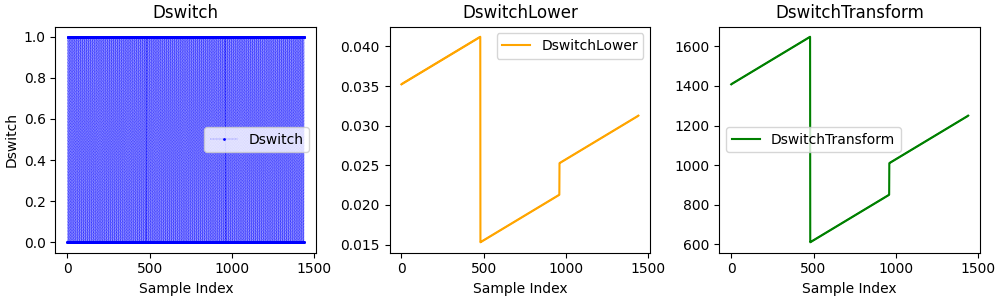